In [1]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 284807 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[ 3.91864870e-15  5.68268579e-16 -8.76173610e-15  2.81111774e-15
 -1.55210305e-15  2.04012968e-15 -1.69895265e-15 -1.95815061e-16
 -3.14764036e-15  1.77292451e-15  9.28952385e-16 -1.80326603e-15
  1.67488824e-15  1.47562122e-15  3.50109813e-15  1.39243845e-15
 -7.46653801e-16  4.25873794e-16  9.02016885e-16  5.12684532e-16
  1.47198194e-16  8.04210901e-16  5.28245009e-16  4.45826738e-15
  1.42689564e-15  1.70163965e-15 -3.67160561e-16 -1.21815215e-16
  8.83496193e+01]
[3.83647578e+00 2.72681045e+00 2.29902117e+00 2.00467678e+00
 1.90507436e+00 1.77494002e+00 1.53039520e+00 1.42647385e+00
 1.20698823e+00 1.18558965e+00 1.04185143e+00 9.98399911e-01
 9.90567315e-01 9.18902320e-01 8.37800459e-01 7.67816427e-01
 7.21370915e-01 7.02536891e-01 6.62659610e-01 5.94323307e-01
 5.39523633e-01 5.26640906e-01 3.89949292e-01 3.66807083e-01
 2.71729873e-01 2.32542076e-01 1.62918619e-01 1.08954579e-01
 6.25598494e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

### Preliminary plotting

[ 1.19185711 -1.35835406 -0.96627171 -1.15823309 -0.42596588  1.22965763
 -0.64426944 -0.89428608 -0.33826175]


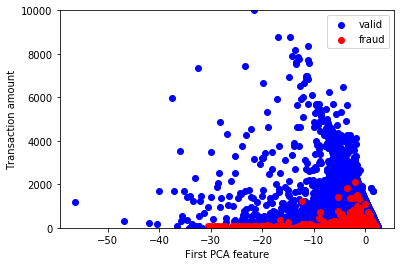

In [4]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [5]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [6]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [7]:
train_binary_SVM(data);

Fold 0
[[56819    44]
 [   33    66]]
Fold 1
[[56829    34]
 [   39    60]]
Fold 2
[[56824    39]
 [   29    69]]
Fold 3
[[56820    43]
 [   38    60]]
Fold 4
[[56829    34]
 [   34    64]]
Final Confusion Matrix
[[5.68242e+04 3.88000e+01]
 [3.46000e+01 6.38000e+01]]
False negatives (valid): 0.0006823417688127605
False positives (fraud): 0.3516260162601626


#### Linear SVM with Scaling

In [8]:
train_binary_SVM(data, scale=True);

Fold 0
[[48725  8138]
 [    5    94]]
Fold 1
[[49241  7622]
 [    2    97]]
Fold 2
[[49706  7157]
 [    2    96]]
Fold 3
[[50615  6248]
 [    7    91]]
Fold 4
[[48501  8362]
 [    5    93]]
Final Confusion Matrix
[[4.93576e+04 7.50540e+03]
 [4.20000e+00 9.42000e+01]]
False negatives (valid): 0.1319909255579199
False positives (fraud): 0.04268292682926829


#### Linear SVM with Scaling and Class Weights

In [9]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[34211 22652]
 [    3    96]]
Fold 1
[[34100 22763]
 [    0    99]]
Fold 2
[[33983 22880]
 [    0    98]]
Fold 3
[[33339 23524]
 [    1    97]]
Fold 4
[[34100 22763]
 [    1    97]]
Final Confusion Matrix
[[3.39466e+04 2.29164e+04]
 [1.00000e+00 9.74000e+01]]
False negatives (valid): 0.403010745124246
False positives (fraud): 0.01016260162601626


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data, scale=True, kernel='rbf');

In [ ]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

#### Polynomial Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data, scale=True, kernel='poly');

In [ ]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

### Logistic Regression

In [ ]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        #err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        #pred_valid = model.predict(data[valid_splits[i]])
        #err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        #pred_fraud = model.predict(data[fraud_splits[i]])
        #err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        #print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        #err += err_fold
        #err_valid += err_valid_fold
        #err_fraud += err_fraud_fold
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        print('Fold', i)
        print(conf_mat)
        print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU
    #err /= 5
    #err_valid /= 5
    #err_fraud /= 5
    #print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    #return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [ ]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))